In [1]:
addprocs(5);

In [2]:
using JuMIT
using PyPlot
pygui(false)
reload("JuMIT")

	Seismic Model:	acou_homo2
	> number of samples:	x	51	z	51
	> vp bounds:	min	1700.0	max	2300.0
	> ρ bounds:	min	1700.0	max	2300.0
	Seismic Model:	

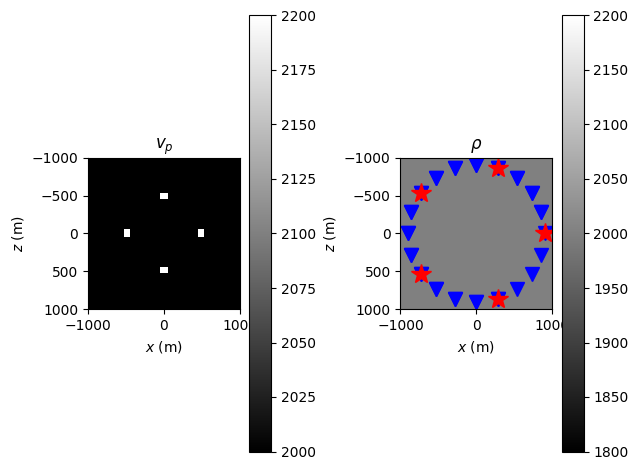

acou_homo2
	> number of samples:	x	51	z	51
	> vp bounds:	min	1700.0	max	2300.0
	> ρ bounds:	min	1700.0	max	2300.0


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2b73baabd4e0>

In [3]:
model = JuMIT.Gallery.Seismic(:acou_homo2);
#model = JuMIT.Models.Seismic_addon(model, circ_rad=10., circ_loc=[-000.,0.],circ_pert=0.2)
JuMIT.Models.Seismic_addon!(model, circ_rad=50., circ_loc=[500.,0.],circ_pert=0.1,randn_perc=0.0, fields=[:χvp])
JuMIT.Models.Seismic_addon!(model, circ_rad=50., circ_loc=[0.,500.],circ_pert=0.1,randn_perc=0.0, fields=[:χvp])
JuMIT.Models.Seismic_addon!(model, circ_rad=50., circ_loc=[-500.,0.],circ_pert=0.1,randn_perc=0.0, fields=[:χvp])
JuMIT.Models.Seismic_addon!(model, circ_rad=50., circ_loc=[0.,-500.],circ_pert=0.1,randn_perc=0.0, fields=[:χvp])
#model = JuMIT.Models.Seismic_addon(model, circ_pert=0.2, rect_loc=[-200.,-500.,200.,500.] )
model0 = JuMIT.Gallery.Seismic(:acou_homo2);
acqgeom = JuMIT.Acquisition.Geom_circ(nss=5,nr=20,rad=[900.,900.])#,θlim=[90.,180.]);

#tgrid = JuMIT.Grid.M1D_resamp(tgrid, tgrid.δx/2.0)
JuMIT.Plots.Seismic(model)
JuMIT.Plots.Geom(acqgeom)

	Source Acquisition:	
	> number of supersources:	5
	> sources per supersource:	min	1	max	1


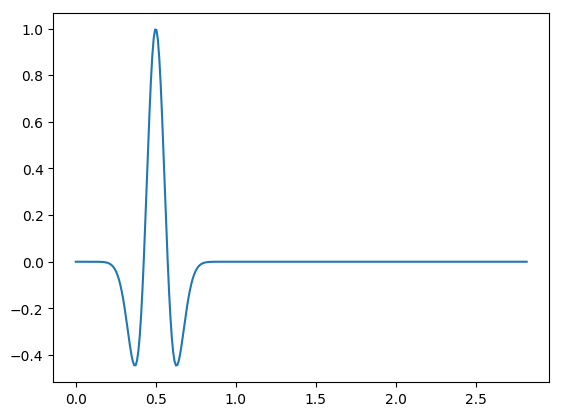

	> frequency:	min	0.224609375	max	9.43359375	peak	2.919921875
	> time:	min	0.0	max	2.8173913043478263
	> samples:	325


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2b73bcbfdd30>

In [4]:
acqsrc=JuMIT.Acquisition.Src_fixed_mod(acqgeom.nss,1,1,model,3)
tgrid=acqsrc.tgrid
JuMIT.Plots.Src(acqsrc)


In [5]:
@time pa = JuMIT.Inversion.Param(acqsrc,mprecon_flag=false, 
    acqgeom, tgrid,:fdtd,:migr,model0,modm_obs=model, igrid=JuMIT.Grid.M2D_resamp(model.mgrid,50.,50.,), 
    verbose=false);

decrease spatial sampling below:	36.041407867494826


 24.811080 seconds (6.63 M allocations: 388.405 MiB, 1.38% gc time)


In [6]:
@time migr2 = JuMIT.Inversion.xfwi!(pa)

maximum value of g(x):	9325.569899953613
  8.818549 seconds (7.57 M allocations: 431.487 MiB, 2.24% gc time)


JuMIT.Models.Seismic([1700.0, 2300.0], [0.0, 0.0], [1700.0, 2300.0], [-12.9159 39.5557 … -81.2313 156.176; -300.493 -193.249 … 77.8972 246.26; … ; -300.512 -193.243 … 77.9057 246.275; -12.9975 39.5186 … -81.2103 156.206], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-36.2347 18.6054 … 13.4212 147.647; -227.11 -145.472 … 135.058 275.324; … ; -193.521 -142.235 … 128.616 239.304; 15.5487 70.1052 … -30.5839 110.252], JuMIT.Grid.M2D([-1000.0, -950.0, -900.0, -850.0, -800.0, -750.0, -700.0, -650.0, -600.0, -550.0  …  550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0], [-1000.0, -950.0, -900.0, -850.0, -800.0, -750.0, -700.0, -650.0, -600.0, -550.0  …  550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0], 41, 41, 50, 50.0, 50.0))

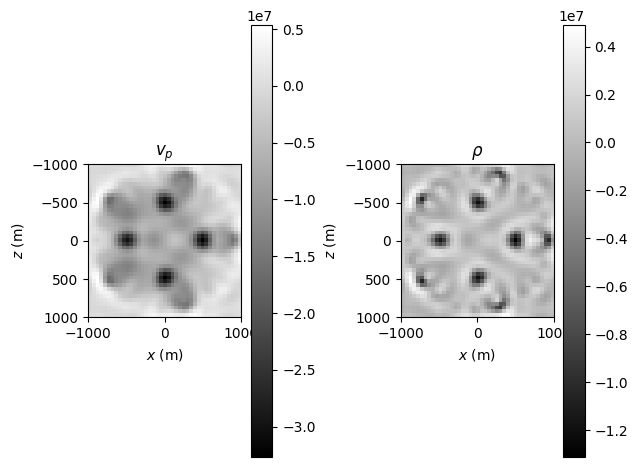

In [7]:
JuMIT.Plots.Seismic(migr2)

In [8]:
@time pac = JuMIT.Inversion.Param(acqsrc,mprecon_flag=true, 
    acqgeom, tgrid,:fdtd,:cls,model0,modm_obs=model, igrid=JuMIT.Grid.M2D_resamp(model.mgrid,50.,50.,));

  1.950982 seconds (298.01 k allocations: 62.883 MiB, 2.31% gc time)


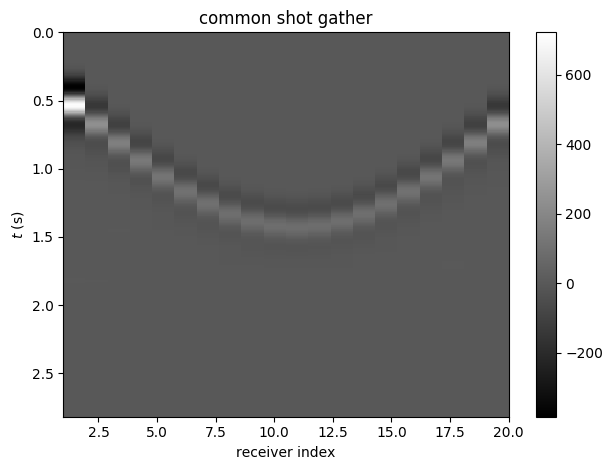

In [9]:
JuMIT.Plots.TD([pa.dobs], attrib=:seis)

In [10]:
@time rcls = JuMIT.Inversion.xfwi!(pac, extended_trace=false)

Iter     Function value   Gradient norm 
     0     1.135196e+04     5.548814e+03
     1     7.214003e+03     3.078801e+03
     2     4.259224e+03     1.549394e+03
Iter     Function value   Gradient norm 
     0     3.370833e+03     1.549574e+03
     1     2.307974e+03     2.080390e+03
     2     1.897138e+03     1.522994e+03
Iter     Function value   Gradient norm 
     0     1.896250e+03     1.522994e+03
     1     1.607272e+03     1.665454e+03
     2     1.189196e+03     7.281087e+02
Iter     Function value   Gradient norm 
     0     1.189195e+03     7.281087e+02
     1     9.512189e+02     1.085950e+03
     2     8.435794e+02     8.488365e+02
Iter     Function value   Gradient norm 
     0     8.435794e+02     8.488365e+02
     1     7.581967e+02     9.334093e+02
     2     6.268238e+02     4.467368e+02
 37.284694 seconds (34.95 M allocations: 6.366 GiB, 4.93% gc time)


Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [-0.17310004415458802,-0.155920423733023, ...]
 * Minimizer: [-0.17256944740858596,-0.15920146353374753, ...]
 * Minimum: 6.268238e+02
 * Iterations: 5
 * Convergence: false
   * |x - x'| < 1.0e-03: false 
     |x - x'| = 7.40e-02 
   * |f(x) - f(x')| / |f(x)| < 1.0e-03: false
     |f(x) - f(x')| / |f(x)| = 3.46e-01 
   * |g(x)| < 1.0e-03: false 
     |g(x)| = 4.47e+02 
   * stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 54
 * Gradient Calls: 54

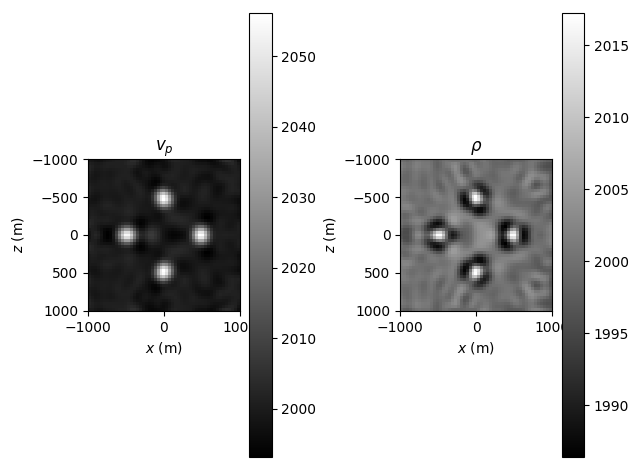

In [11]:
JuMIT.Plots.Seismic(pac.modm)